In [52]:
# Import libraries 
import json
# import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import gc
import pickle
import IPython.display as ipd 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import sys

# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# EDA

In [2]:
TESS = "toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
SAVEE = "surrey-audiovisual-expressed-emotion-savee/ALL/"
CREMA = "cremad/AudioWAV/"

# Directory validation
dir_list = os.listdir(SAVEE)
dir_list[0:5]

['JE_d08.wav', 'JE_d13.wav', 'JK_sa12.wav', 'DC_h03.wav', 'KL_n02.wav']

In [3]:
# Listing all available files in SAVEE
dir_list = os.listdir(SAVEE)

# emotions data fetching
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Check the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_disgust      60
male_sad          60
male_happy        60
male_surprise     60
male_fear         60
male_angry        60
Name: labels, dtype: int64

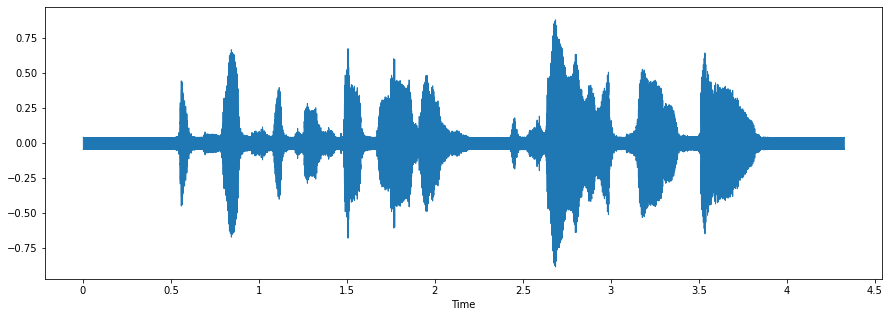

In [4]:
# Sample file view from SAVEE directory
SAVEE_file0 = SAVEE + 'DC_f11.wav'  
data, sampling_rate = librosa.load(SAVEE_file0)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
# Check audio in notebook
ipd.Audio(SAVEE_file0)

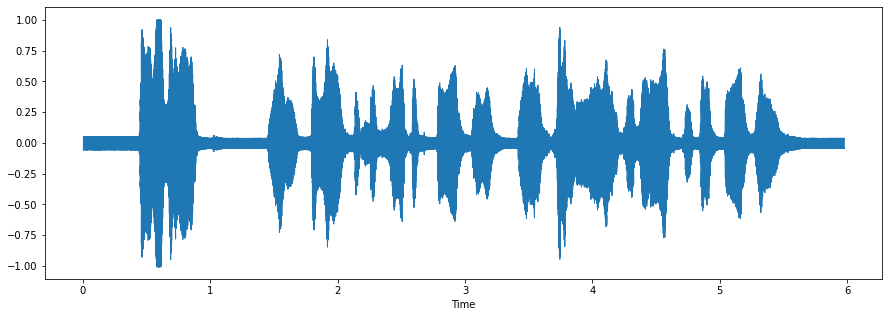

In [5]:
# Another file view from SAVEE directory
SAVEE_file1 = SAVEE + 'DC_h11.wav'  
data, sampling_rate = librosa.load(SAVEE_file1)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Check audio in notebook
ipd.Audio(SAVEE_file1)

### RAVDESS dataset

In [6]:
RAV_dir_list = os.listdir(RAV)
RAV_dir_list.sort()

emotion = []
gender = []
path = []
for i in RAV_dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_happy          96
male_fear           96
male_angry          96
male_disgust        96
male_surprise       96
male_sad            96
female_disgust      96
female_sad          96
female_angry        96
female_happy        96
female_fear         96
female_surprise     96
Name: labels, dtype: int64

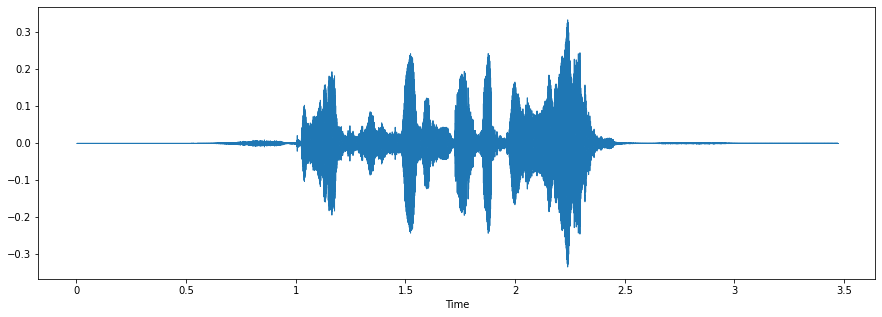

In [7]:
# Sample file view from RAV directory
fearful_audio = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fearful_audio)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Check audio in notebook
ipd.Audio(fearful_audio)


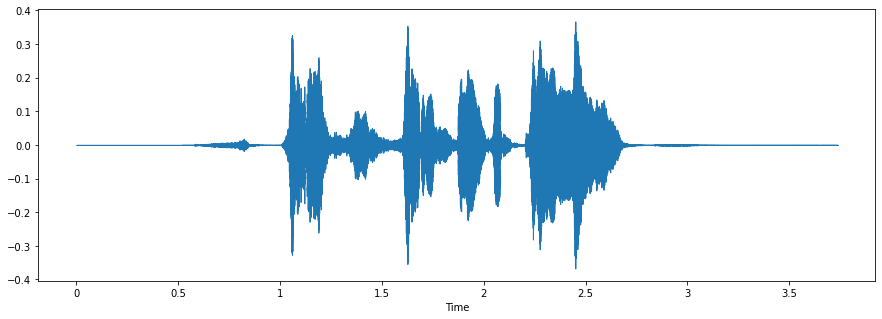

In [8]:
# Sample file view from RAV directory
happy_audio =  RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(happy_audio)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
# Check audio in notebook

ipd.Audio(happy_audio)

### TESS dataset

In [9]:
# Listing some of the TESS dataset samples
TESS_dir_list = os.listdir(TESS)
TESS_dir_list.sort()
TESS_dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [10]:
path = []
emotion = []
# Making emotion records for the main data
for i in TESS_dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

# Checking label counts of each class
TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_fear        400
female_surprise    400
female_sad         400
female_angry       400
female_disgust     400
female_happy       400
female_neutral     400
Name: labels, dtype: int64

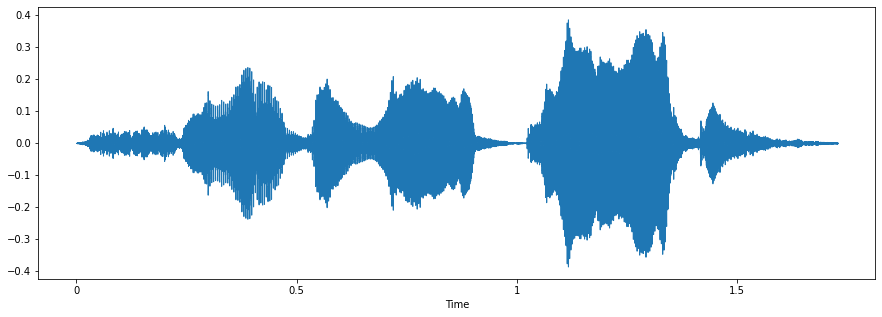

In [11]:
# Sample file view from TESS directory
TESS_audio_sample = TESS + 'YAF_fear/YAF_dog_fear.wav' 

data, sampling_rate = librosa.load(TESS_audio_sample)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Check audio in notebook
ipd.Audio(TESS_audio_sample)

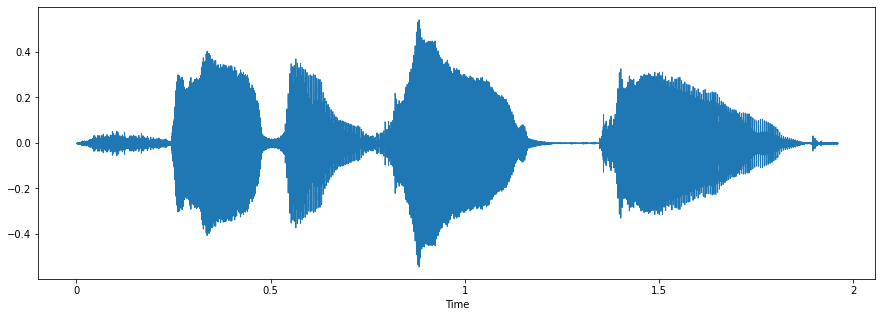

In [12]:
# Sample file view from TESS directory
fname =  TESS + 'YAF_happy/YAF_dog_happy.wav' 

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

### CREMA-D dataset

In [13]:
# Listing some of the CREMA dataset samples
CREMA_dir_list = os.listdir(CREMA)
CREMA_dir_list.sort()
print(CREMA_dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [14]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

# Making emotion records for the main data

for i in CREMA_dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)

# Checking label counts of each class
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_angry      600
female_disgust    600
female_fear       600
female_happy      600
female_sad        600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

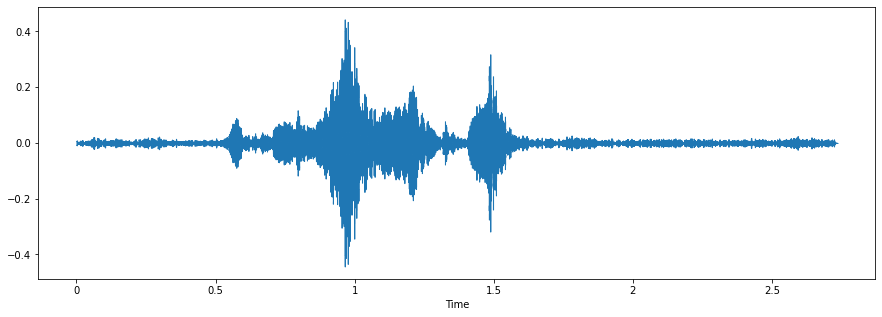

In [15]:
# Sample file view from CREMA directory
CREMA_fname0 = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(CREMA_fname0)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)


# play the audio 
ipd.Audio(CREMA_fname0)

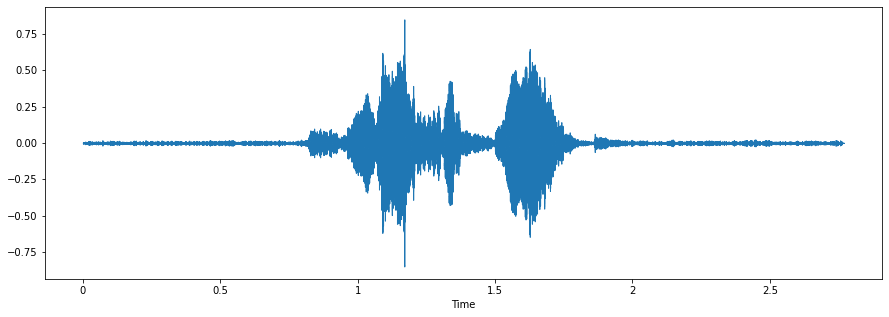

In [16]:
# Sample file view from CREMA directory
CREMA_fname1 = CREMA + '1012_IEO_FEA_HI.wav'  
data, sampling_rate = librosa.load(CREMA_fname1)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# play the audio 
ipd.Audio(CREMA_fname1)

In [17]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_disgust     1096
female_sad         1096
female_angry       1096
female_happy       1096
female_fear        1096
female_neutral     1056
male_neutral        839
male_disgust        827
male_sad            827
male_happy          827
male_fear           827
male_angry          827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64


# Feature Extraction

## Time domain features

In [36]:
# RMS Feature Extraction 
def rms_feature(path, plotting = False, ret_len = False, colorbar=False):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    rms_feat = librosa.feature.rms(y=X,)
    if plotting:
        plt.figure(figsize=(20, 15))
        plt.subplot(3,1,1)
        librosa.display.waveshow(rms_feat, sr=sample_rate)
        plt.title('RMS')
    if ret_len:
        print(len(rms_feat))
    return rms_feat
# Zero Crossing Feature Extraction
def zero_crossing_feature(path, plotting = False, ret_len = False):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    zero_crossing = librosa.feature.zero_crossing_rate(y=X,)
    if plotting:
        plt.figure(figsize=(20, 15))
        plt.subplot(3,1,1)
        librosa.display.waveshow(zero_crossing, sr=sample_rate)
        plt.title('Zero Crossing')
    if ret_len:
        print(len(zero_crossing))
    return zero_crossing

###### RMS feature extraction

array([[0.0282505 , 0.03470824, 0.04185944, 0.10153226, 0.15125495,
        0.17204899, 0.18174854, 0.15785803, 0.11141016, 0.07534491,
        0.04576294, 0.04057955, 0.03990443, 0.04005722, 0.04012614,
        0.04098018, 0.04140683, 0.04169776, 0.04202675, 0.04155013,
        0.04137807, 0.04113128, 0.04082083, 0.04465548, 0.07824525,
        0.11284386, 0.16051044, 0.2113311 , 0.24400307, 0.26340893,
        0.26267588, 0.24242668, 0.20178346, 0.15583564, 0.10795122,
        0.05157432, 0.04102956, 0.04049725, 0.04103063, 0.04147869,
        0.04238982, 0.04288811, 0.04295731, 0.04420864, 0.04433482,
        0.04425426, 0.04356207, 0.04161527, 0.0422968 , 0.06835755,
        0.1143029 , 0.1573968 , 0.17421474, 0.16805986, 0.14132756,
        0.09098747, 0.05046269, 0.04160868, 0.04005577, 0.03998887,
        0.04105841, 0.04215369, 0.0422974 , 0.04535817, 0.08459798,
        0.11435395, 0.13568176, 0.1513056 , 0.1505008 , 0.14796063,
        0.13854507, 0.12182776, 0.10066442, 0.07

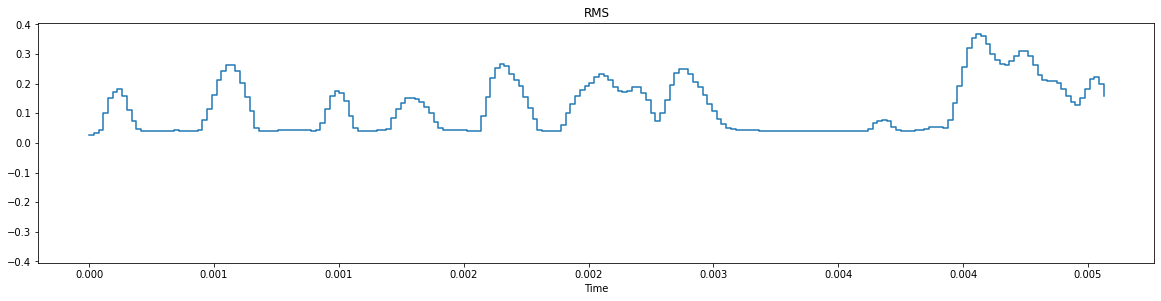

In [39]:
rms_feature(SAVEE_file0, plotting = True)

array([[0.2617807 , 0.31915075, 0.35440248, 0.35576826, 0.39056614,
        0.4797632 , 0.59065545, 0.6822478 , 0.7102509 , 0.65326154,
        0.5428007 , 0.3879068 , 0.2387852 , 0.18750732, 0.29940295,
        0.39988452, 0.43206325, 0.45860222, 0.42890075, 0.36163515,
        0.34732306, 0.33994442, 0.33031783, 0.3369202 , 0.33541402,
        0.32228905, 0.3065036 , 0.29648623, 0.29771832, 0.2969609 ,
        0.27509418, 0.2463464 , 0.19351654, 0.13040276, 0.08864401,
        0.04466761, 0.04072581, 0.04033554, 0.04012179, 0.04012581,
        0.04014159, 0.04018901, 0.04013685, 0.03996458, 0.04035646,
        0.04040745, 0.04055111, 0.04057147, 0.04010083, 0.03988989,
        0.03972457, 0.03966559, 0.03965649, 0.03970481, 0.03971342,
        0.03964185, 0.03958527, 0.03954699, 0.03946555, 0.03957003,
        0.03960066, 0.03953474, 0.03953855, 0.03958137, 0.0394992 ,
        0.0395979 , 0.03962369, 0.03952841, 0.03959817, 0.03967014,
        0.03983407, 0.03997036, 0.04014646, 0.04

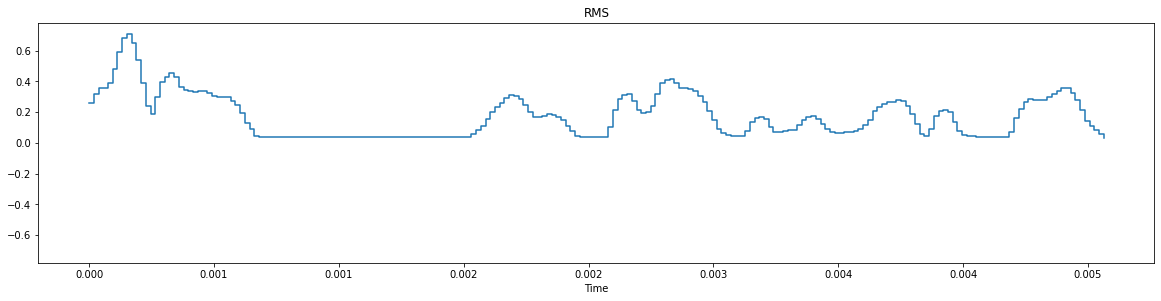

In [42]:
rms_feature(SAVEE_file1, plotting = True)

##### Zero Crossing feature extraction

array([[0.07177734, 0.22167969, 0.37255859, 0.56005859, 0.64453125,
        0.59130859, 0.45507812, 0.30957031, 0.20361328, 0.15917969,
        0.19335938, 0.19921875, 0.20263672, 0.20898438, 0.21386719,
        0.21923828, 0.21875   , 0.21337891, 0.21679688, 0.21240234,
        0.2109375 , 0.20751953, 0.20703125, 0.20556641, 0.19873047,
        0.1953125 , 0.16455078, 0.12451172, 0.08886719, 0.05859375,
        0.04589844, 0.05761719, 0.06152344, 0.07275391, 0.10498047,
        0.15527344, 0.23583984, 0.25732422, 0.29541016, 0.35058594,
        0.33251953, 0.38769531, 0.421875  , 0.41113281, 0.45166016,
        0.37988281, 0.27001953, 0.1640625 , 0.06005859, 0.05029297,
        0.06884766, 0.07519531, 0.09228516, 0.08642578, 0.07324219,
        0.07568359, 0.06201172, 0.06103516, 0.06640625, 0.06640625,
        0.0625    , 0.05419922, 0.04296875, 0.03125   , 0.03662109,
        0.12207031, 0.23339844, 0.34619141, 0.45166016, 0.49316406,
        0.49707031, 0.46582031, 0.36132812, 0.23

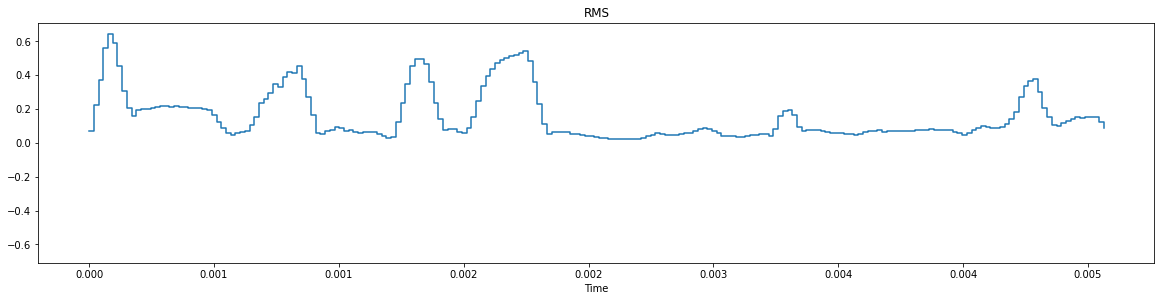

In [72]:
zero_crossing_feature(happy_audio, plotting = True)

array([[0.00292969, 0.03808594, 0.03808594, 0.13525391, 0.25      ,
        0.38378906, 0.54785156, 0.58886719, 0.58007812, 0.4921875 ,
        0.39794922, 0.32373047, 0.27978516, 0.26123047, 0.25537109,
        0.26269531, 0.26855469, 0.28613281, 0.29541016, 0.30175781,
        0.30175781, 0.30322266, 0.30175781, 0.30615234, 0.31396484,
        0.30957031, 0.30810547, 0.30175781, 0.30078125, 0.29492188,
        0.29248047, 0.27832031, 0.26074219, 0.24902344, 0.23681641,
        0.21972656, 0.19677734, 0.17871094, 0.16894531, 0.16552734,
        0.15332031, 0.15625   , 0.18701172, 0.20507812, 0.18945312,
        0.15332031, 0.08837891, 0.04052734, 0.04394531, 0.04638672,
        0.04492188, 0.04296875, 0.04492188, 0.046875  , 0.04785156,
        0.05175781, 0.05810547, 0.06298828, 0.06201172, 0.05761719,
        0.04833984, 0.04492188, 0.08691406, 0.17041016, 0.26171875,
        0.36572266, 0.4296875 , 0.44238281, 0.43066406, 0.33886719,
        0.23046875, 0.13134766, 0.0546875 , 0.05

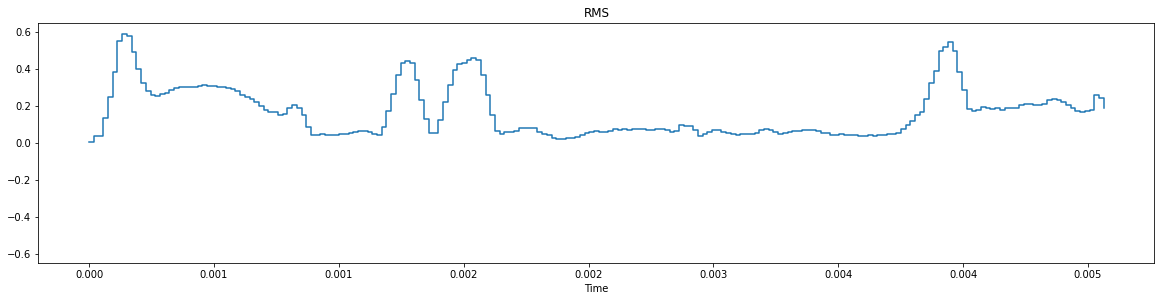

In [73]:
zero_crossing_feature(fearful_audio, plotting = True)

## Frequency domain features

In [46]:
# MFCC Feature Extraction
def mfcc_feature(path, plotting = False, ret_len = False):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate)
    if plotting:
        plt.figure(figsize=(20, 15))
        plt.subplot(3,1,1)
        librosa.display.waveshow(mfcc, sr=sample_rate)
        plt.title('MFCC')
    if ret_len:
        print(len(mfcc))
    return mfcc    
# Mel Spectrogram Feature Extraction
def mel_spectrogram_feature(path, plotting = False):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    mel_spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate)
    if plotting:
        plt.figure(figsize=(20, 15))
        plt.subplot(3,1,1)
        librosa.display.waveshow(mel_spectrogram, sr=sample_rate)
        plt.title('Mel Spectrogram')
    return mel_spectrogram
# Chroma Frequency Feature Extraction
def chroma_freq_feature(path, plotting = False):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    chroma_freq = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    if plotting:
        plt.figure(figsize=(20, 15))
        plt.subplot(3,1,1)
        librosa.display.waveshow(chroma_freq, sr=sample_rate)
        plt.title('Chroma Frequencies')
    return chroma_freq
# Spectral Centroid Feature Extraction
def spectral_cent_feature(path, plotting = False):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    spectral_cent = librosa.feature.spectral_centroid(y=X, sr=sample_rate)
    if plotting:
        plt.figure(figsize=(20, 15))
        plt.subplot(3,1,1)
        librosa.display.waveshow(spectral_cent, sr=sample_rate)
        plt.title('Specteral Centroid')
    return spectral_cent
# Spectral Roll Off Feature Extraction
def spectral_roll_off_feature(path, plotting = False):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    spectral_roll_off = librosa.feature.spectral_rolloff(y=X, sr=sample_rate)
    if plotting:
        plt.figure(figsize=(20, 15))
        plt.subplot(3,1,1)
        librosa.display.waveshow(spectral_roll_off, sr=sample_rate)
        plt.title('Spectral Roll off')
    return spectral_roll_off
# Linear Prediction Co-efficients Feature Extraction
def LPC_feature(path, plotting = False):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
    LPC = librosa.lpc(y=X, order=16)
    if plotting:
        plt.figure(figsize=(20, 15))
        plt.subplot(3,1,1)
        librosa.display.waveshow(LPC, sr=sample_rate)
        plt.title('Linear Prediction Coefficient')
    return LPC



##### MFCC feature extraction

array([[-363.92606  , -418.52158  , -467.81174  , ..., -245.41132  ,
        -250.17722  , -277.85464  ],
       [ 124.51268  ,  110.60597  ,   76.909515 , ...,  225.29935  ,
         234.49911  ,  207.4688   ],
       [  19.49536  ,   32.749214 ,   47.97809  , ...,    5.140417 ,
          25.223265 ,   39.25074  ],
       ...,
       [   3.6381996,    4.7455626,    6.6975317, ...,   20.533276 ,
          17.552906 ,    9.776861 ],
       [   3.3960774,    3.9052536,  -10.020994 , ...,   -6.5430603,
          -1.4612095,    7.5112534],
       [   3.2284718,    3.7059402,  -11.4292345, ...,  -11.9908085,
         -11.460378 ,   -1.9877331]], dtype=float32)

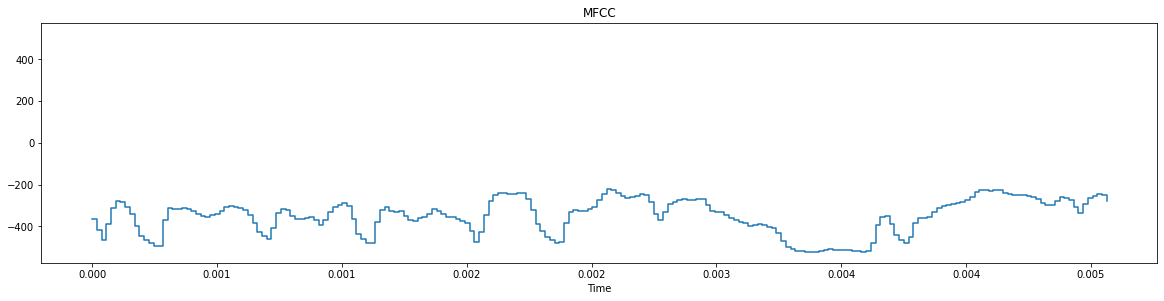

In [49]:
mfcc_feature(SAVEE_file0, plotting = True)

array([[ -69.444176 , -106.57328  , -182.92668  , ..., -298.41223  ,
        -306.74652  , -303.42593  ],
       [ 145.82532  ,  167.13106  ,  204.98552  , ...,  118.69063  ,
          96.72989  ,   93.3846   ],
       [  10.3751135,    1.772783 ,  -26.964733 , ...,   23.515821 ,
          11.00516  ,    3.3652644],
       ...,
       [   2.212819 ,    8.923393 ,    9.843955 , ...,   13.540335 ,
          19.693144 ,   17.767555 ],
       [  -2.9890444,   -4.819311 ,  -22.402971 , ...,    3.658607 ,
           7.1897964,    1.8028042],
       [  -2.3948627,   -8.974633 ,   -9.395447 , ...,   -9.9345875,
          -8.497017 ,   -7.562952 ]], dtype=float32)

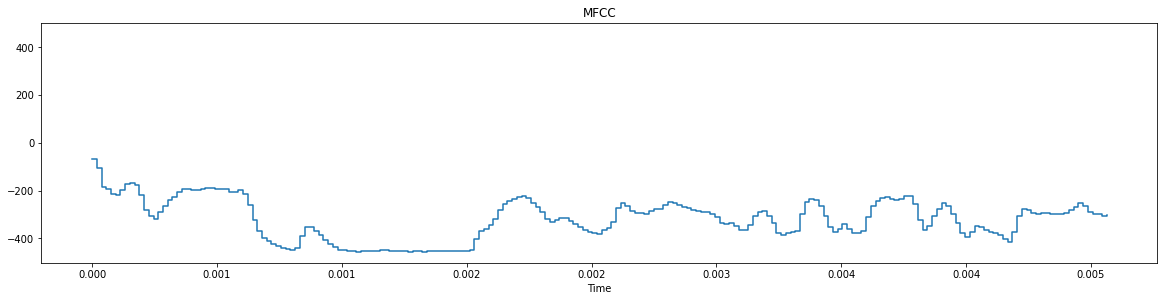

In [50]:
mfcc_feature(SAVEE_file1, plotting = True)

##### Mel Spectrogram feature extraction

array([[7.6803603e+00, 1.1132241e+01, 9.4600601e+00, ..., 9.4669600e+00,
        9.9795437e+00, 1.0344418e+01],
       [1.6227480e+00, 3.1707251e-01, 2.5112517e-03, ..., 1.1113666e-02,
        6.3404970e-02, 9.9530458e-01],
       [4.9002576e-01, 1.5311868e-01, 2.3524174e-03, ..., 1.2724937e-02,
        2.3077278e-01, 2.0595346e-01],
       ...,
       [1.7789122e-05, 4.4368717e-06, 7.1255748e-09, ..., 6.9708932e-09,
        1.2594155e-06, 1.7242248e-05],
       [1.7563787e-05, 4.3802665e-06, 5.7956666e-09, ..., 8.3582119e-09,
        1.2648469e-06, 1.7292126e-05],
       [1.7542312e-05, 4.3788946e-06, 7.3125652e-09, ..., 6.3747598e-09,
        1.2523579e-06, 1.7193874e-05]], dtype=float32)

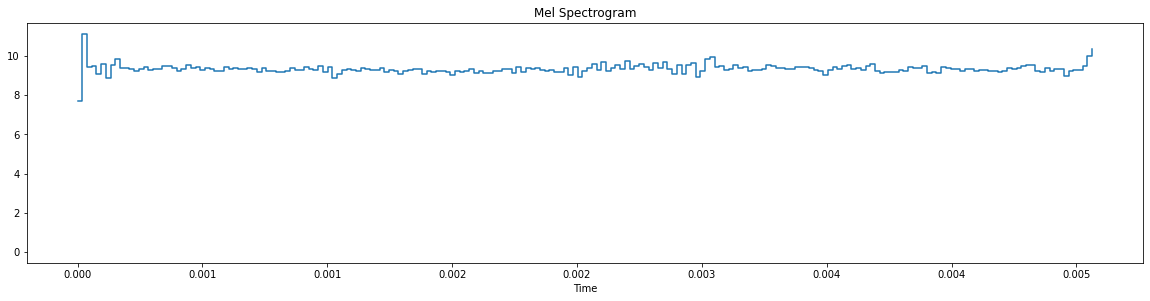

In [51]:
mel_spectrogram_feature(SAVEE_file0, plotting = True)

array([[1.3338892e+01, 1.7735044e+01, 1.4937137e+01, ..., 9.4206972e+00,
        9.9155989e+00, 1.0296895e+01],
       [2.7990098e+00, 4.9675086e-01, 1.8439762e-03, ..., 6.4421245e-03,
        5.9720740e-02, 1.3930225e+00],
       [8.9907169e-01, 2.3070596e-01, 9.7918585e-03, ..., 5.2037505e-03,
        3.6557220e-02, 3.2359564e-01],
       ...,
       [4.0772106e-03, 1.0161740e-03, 6.8946706e-09, ..., 7.0133472e-09,
        7.5230093e-07, 1.0254846e-05],
       [4.0260456e-03, 1.0033110e-03, 9.0889154e-09, ..., 7.3174689e-09,
        7.4698107e-07, 1.0155808e-05],
       [3.9985031e-03, 9.9647918e-04, 6.4117791e-09, ..., 6.3362080e-09,
        7.3648084e-07, 1.0073801e-05]], dtype=float32)

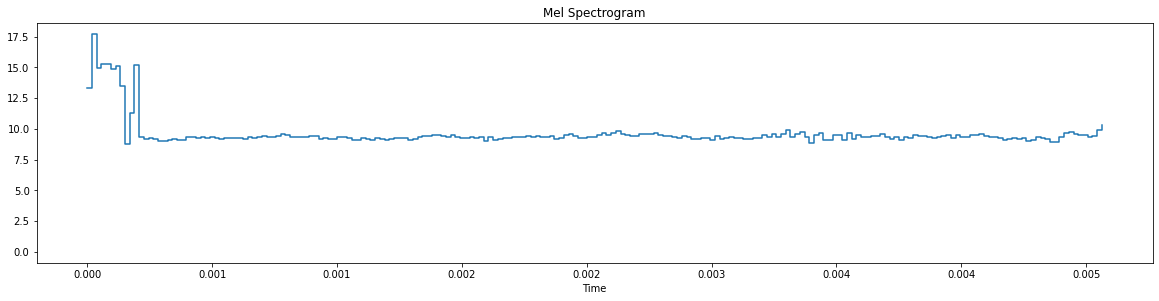

In [52]:
mel_spectrogram_feature(SAVEE_file1, plotting = True)

##### Chroma Frequencies feature extraction

array([[0.7692258 , 0.78486896, 0.77337825, ..., 1.        , 1.        ,
        1.        ],
       [0.8123227 , 0.83574885, 0.82885885, ..., 0.7264364 , 0.5243333 ,
        0.8135862 ],
       [0.875613  , 0.9076552 , 0.9059989 , ..., 0.05561495, 0.06901795,
        0.3027556 ],
       ...,
       [0.8441685 , 0.8778075 , 0.8045437 , ..., 0.01596244, 0.04789438,
        0.1892412 ],
       [0.78490853, 0.816566  , 0.7427565 , ..., 0.02296208, 0.12848467,
        0.565762  ],
       [0.7200241 , 0.73540777, 0.6956461 , ..., 0.20350899, 0.5126624 ,
        0.8664056 ]], dtype=float32)

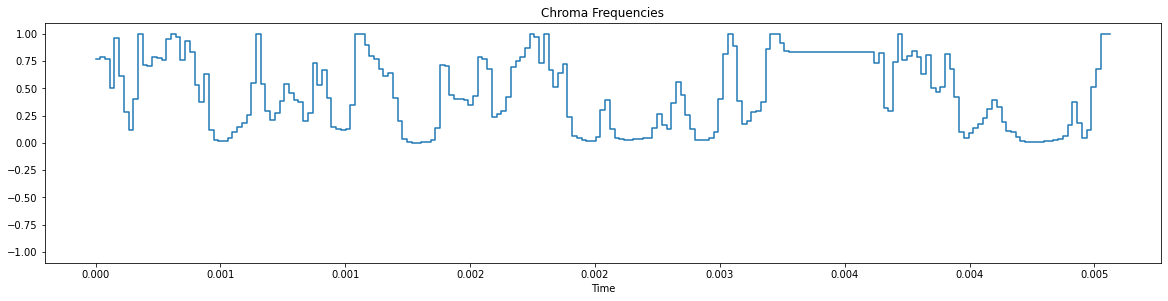

In [53]:
chroma_freq_feature(SAVEE_file0, plotting = True)

array([[0.05019587, 0.01883448, 0.00936342, ..., 0.07787857, 0.22366306,
        0.5443333 ],
       [0.06364499, 0.02101867, 0.01270812, ..., 0.14322011, 0.44764835,
        0.6901644 ],
       [0.2460301 , 0.06309231, 0.01399707, ..., 0.27494168, 0.83112884,
        0.9323351 ],
       ...,
       [0.4139462 , 0.46312505, 0.45705906, ..., 0.16453494, 0.37580732,
        0.51509887],
       [0.16845077, 0.12487078, 0.24720727, ..., 0.04469233, 0.13344832,
        0.4159952 ],
       [0.06990115, 0.01918888, 0.03224782, ..., 0.03334457, 0.14137678,
        0.43779337]], dtype=float32)

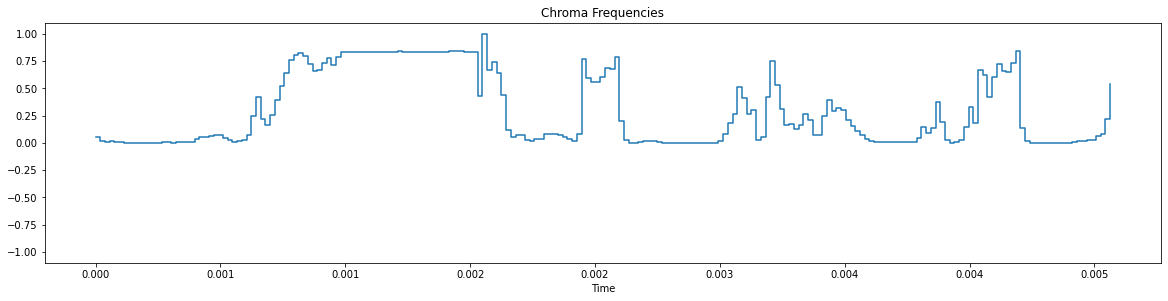

In [54]:
chroma_freq_feature(SAVEE_file1, plotting = True)

##### Spectral Centroid feature extraction

array([[2584.59252318, 1580.61257042,  300.75250199,  426.67081683,
         528.76958123,  594.6036368 ,  607.23928236,  551.90533709,
         467.15353771,  357.01044189,  283.95394946,  229.84380241,
         171.70653894,  136.79553558,  180.15524626, 1090.27455419,
        1442.66367346, 1399.48523946, 1597.73832584, 1677.0698286 ,
        1640.5571375 , 1573.3013218 , 1449.15497744, 1111.78386304,
         586.56660946,  470.39832369,  498.22448005,  579.96474298,
         658.52283732,  670.42521338,  655.91979737,  621.41709385,
         566.68623398,  483.935356  ,  385.50557383,  300.96702365,
         250.2686932 ,  221.33704401,  847.92261643, 1762.37716199,
        2402.94809248, 3010.91116812, 3252.42760883, 3469.57013972,
        3711.48198363, 3744.22178485, 3275.96074108, 2407.41068655,
        1580.58690425,  890.14322825,  512.25670039,  495.95427949,
         546.43662322,  596.39703746,  632.47539796,  592.8901259 ,
         312.29350603,  259.83072284,  204.45058

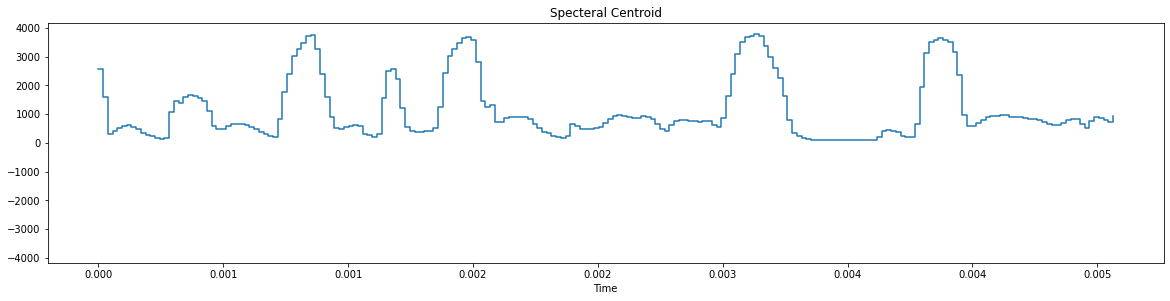

In [55]:
spectral_cent_feature(SAVEE_file0, plotting = True)

array([[2910.08095695, 1917.68118035, 1005.11619519,  981.51078671,
         857.39454963,  821.66413487,  842.4416897 ,  987.89914277,
         990.20884717,  870.13536548,  706.03571787,  579.73884059,
         546.42356082,  511.6573767 ,  570.41694277,  602.79723664,
         642.32720793,  738.19607513,  918.75729607,  948.9726782 ,
         912.37003742,  972.9805697 , 1024.56636128, 1050.36317339,
        1099.21027709, 1123.17463892, 1097.31396268, 1108.71061655,
        1120.81105255, 1086.15957249, 1029.85609   , 1016.90887217,
         905.15884463,  697.71130401,  598.985455  ,  508.13583148,
         371.73694064,  289.64666004,  226.86523546,  193.6069361 ,
         158.87490244,  132.82797175,  112.76022171,  187.4655164 ,
         587.76675471,  995.60015208, 1442.89947064, 1747.12461676,
        1502.71212736, 1081.70088589,  711.04679632,  427.69249344,
         253.40736277,  188.06610795,  149.24190214,  140.17167649,
         131.48145658,  115.72453867,  111.02724

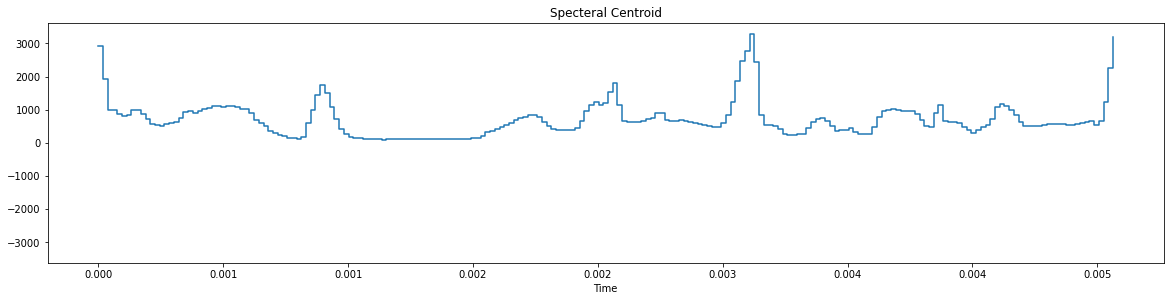

In [56]:
spectral_cent_feature(SAVEE_file1, plotting = True)

##### Spectral Roll Off feature extraction

array([[6201.5625    , 2433.25195312,  279.93164062,  559.86328125,
         624.46289062,  667.52929688,  645.99609375,  624.46289062,
         602.9296875 ,  516.796875  ,  495.26367188,  387.59765625,
         129.19921875,   21.53320312,   21.53320312, 2691.65039062,
        2971.58203125, 2734.71679688, 3682.17773438, 3940.57617188,
        3811.37695312, 3768.31054688, 3617.578125  , 2411.71875   ,
         882.86132812,  624.46289062,  753.66210938,  904.39453125,
         947.4609375 ,  947.4609375 ,  925.92773438,  925.92773438,
         775.1953125 ,  732.12890625,  602.9296875 ,  559.86328125,
         516.796875  ,  387.59765625, 2476.31835938, 4242.04101562,
        4608.10546875, 5189.50195312, 5663.23242188, 5921.63085938,
        5900.09765625, 5986.23046875, 5792.43164062, 4974.16992188,
        3919.04296875, 2304.05273438,  559.86328125,  559.86328125,
         667.52929688,  839.79492188,  667.52929688,  516.796875  ,
         366.06445312,  344.53125   ,  172.26562

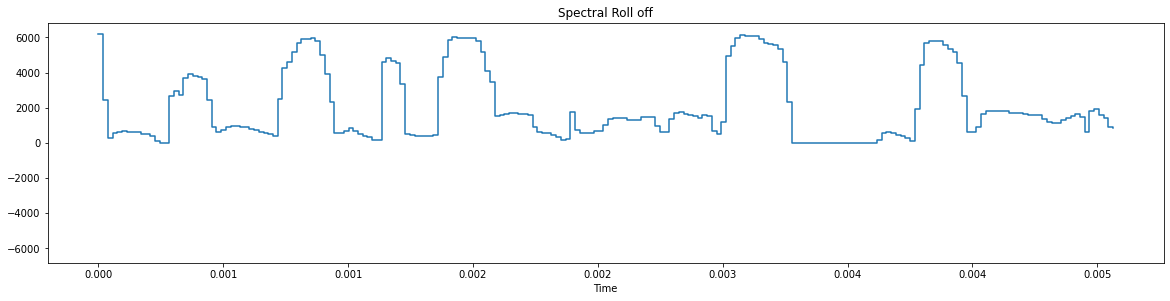

In [57]:
spectral_roll_off_feature(SAVEE_file0, plotting = True)

array([[6072.36328125, 2627.05078125, 1744.18945312, 1808.7890625 ,
        1614.99023438, 1808.7890625 , 1744.18945312, 1916.45507812,
        1679.58984375, 1270.45898438,  839.79492188,  473.73046875,
         581.39648438,  538.33007812,  624.46289062,  645.99609375,
         667.52929688,  861.328125  , 1679.58984375, 1636.5234375 ,
        1571.92382812, 1593.45703125, 1787.25585938, 2002.58789062,
        2196.38671875, 2174.85351562, 1981.0546875 , 1981.0546875 ,
        2024.12109375, 1873.38867188, 1701.12304688, 1722.65625   ,
        1658.05664062,  947.4609375 ,  775.1953125 ,  775.1953125 ,
         753.66210938,  710.59570312,  344.53125   ,  107.66601562,
          21.53320312,   21.53320312,   21.53320312,   21.53320312,
         968.99414062, 1808.7890625 , 4586.57226562, 5663.23242188,
        4866.50390625, 2906.98242188, 1765.72265625,  409.13085938,
          21.53320312,   21.53320312,   21.53320312,   21.53320312,
          21.53320312,   21.53320312,   21.53320

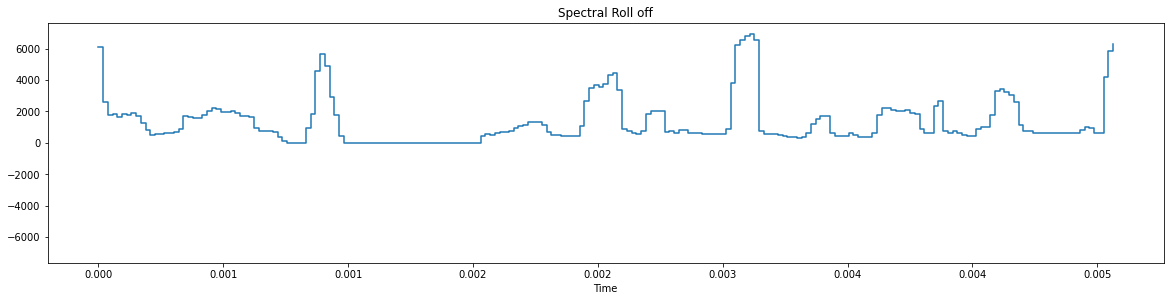

In [58]:
spectral_roll_off_feature(SAVEE_file1, plotting = True)

##### Linear Prediction Coefficient feature extraction

array([ 1.0000000e+00, -1.2486110e+03,  5.1515800e+05, -7.9304208e+07,
        3.6381501e+09, -2.2806837e+10,  5.6900731e+10, -7.8492606e+10,
        7.6792136e+10, -6.9930476e+10,  6.0150444e+10, -3.6019368e+10,
        1.0238533e+10, -3.9473795e+08,  3.3784978e+06, -9.5968486e+03,
        8.5032091e+00], dtype=float32)

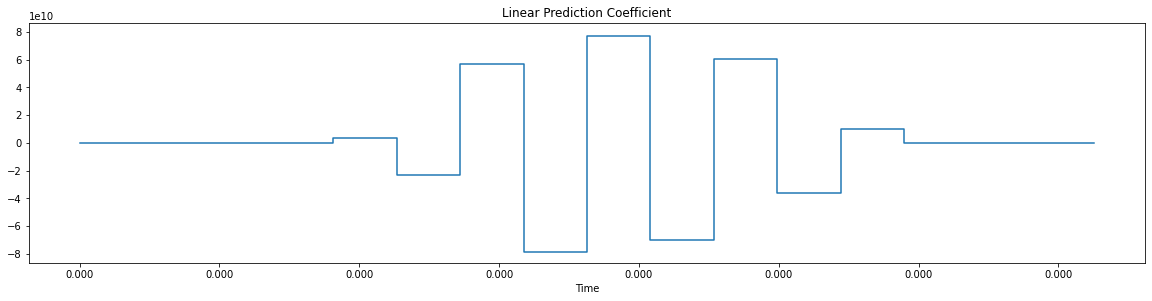

In [59]:
LPC_feature(SAVEE_file0, plotting = True)

array([ 1.00000000e+00, -4.97910430e+04,  7.57504960e+08, -3.56771273e+12,
        2.54659644e+15, -8.30684213e+16,  4.92563583e+17, -6.37665960e+17,
       -2.99700619e+17,  1.02392096e+18, -5.63999540e+17,  6.33566990e+16,
        2.18957111e+15, -1.44038842e+14,  5.08479488e+10, -4.29826500e+06,
        1.00791901e+02], dtype=float32)

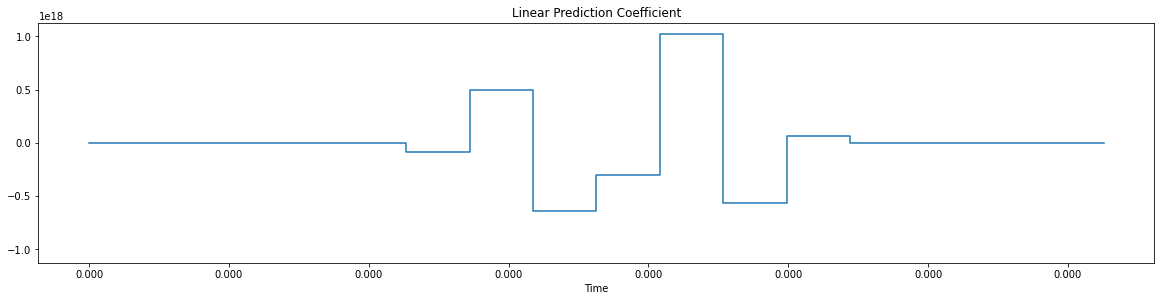

In [60]:
LPC_feature(SAVEE_file1, plotting = True)

# Deep Learning Model

In [2]:
# Read the dataset for getting all the paths to the audio files.
ref = pd.read_csv("Data_path.csv")
ref.head()

,labels,source,path
0,male_disgust,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...
1,male_disgust,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...
2,male_sad,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...
3,male_happy,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...
4,male_neutral,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...


In [86]:
def pre_processing(data_set, feat = None):
    df = pd.DataFrame(columns=['feature'])
    # loop  the respected feature extraction technique over the entire dataset
    counter=0
    for index,path in enumerate(data_set.path):
        X, sample_rate = librosa.load(path
                                      ,res_type='kaiser_fast'
                                      ,duration=2.5
                                      ,sr=44100
                                      ,offset=0.5
                                     )
        sample_rate = np.array(sample_rate)
        if feat == 'zero_crossing':
            features = np.mean(librosa.feature.zero_crossing_rate(y=X), axis=0)
        elif feat == 'rms':
            features = np.mean(librosa.feature.rms(y=X), axis=0)
        elif feat == 'mfcc':
            features = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate), axis=0)                       
        elif feat == 'mel_spectrogram':
            features = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate), axis=0)                                  
        elif feat == 'chroma_freq':
            features = np.mean(librosa.feature.chroma_stft(y=X, sr=sample_rate), axis=0)                                                
        elif feat == 'spectral_centroid':
            features = np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate), axis=0)                                        
        elif feat == 'spectral_rolloff':
            features = np.mean(librosa.feature.spectral_rolloff(y=X, sr=sample_rate), axis=0)                             
        elif feat == 'lpc':
            features = np.mean(librosa.lpc(y=X, order=16), axis=0)                       
        print(f'processing {feat} features')
        df.loc[counter] = [features]
        counter=counter+1
    df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
    df=df.fillna(0)
    # Split between train and test 
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )
    # Taking mean and standard deviation for scaling the data
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    # Data Normalization
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std
    max_data = np.max(X_train)
    min_data = np.min(X_train)
    X_train = (X_train-min_data)/(max_data-min_data+1e-6)
    X_train =  X_train-0.5
    max_data = np.max(X_test)
    min_data = np.min(X_test)
    X_test = (X_test-min_data)/(max_data-min_data+1e-6)
    X_test =  X_test-0.5
    # Converting the data to ndarray
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # First label encode and then doing one hot encoding to make columns for all available features 
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_test = to_categorical(lb.fit_transform(y_test))
    # pickling the labels for later use
    filename = 'labels'
    outfile = open(filename,'wb')
    pickle.dump(lb,outfile)
    outfile.close()
    # expanding dimensions for readying the data for training
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    return X_train, y_train, X_test, y_test

## Feature Selecion

In [105]:
# dummy model for feature selection
def dummy_model_def():
    # Defining a squential model
    dummy_model = Sequential()
    # Defining a 1 Dimensional Convonutional layer
    dummy_model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
    # Defining an activation layer
    dummy_model.add(Activation('relu'))
    dummy_model.add(Conv1D(256, 8, padding='same'))
    # Defining a batch normalization layer 
    dummy_model.add(BatchNormalization())
    dummy_model.add(Activation('relu'))
    # Defining an Dropout layer 
    dummy_model.add(Dropout(0.25))
    dummy_model.add(Conv1D(128, 8, padding='same'))
    dummy_model.add(BatchNormalization())
    dummy_model.add(Activation('relu'))
    dummy_model.add(Dropout(0.25))
    # Defining a Max pooling layer
    dummy_model.add(MaxPooling1D(pool_size=(8)))
    dummy_model.add(Conv1D(64, 8, padding='same'))
    dummy_model.add(Activation('relu'))
    dummy_model.add(Conv1D(64, 8, padding='same'))
    dummy_model.add(Activation('relu'))
    # Defining a Flattening layer
    dummy_model.add(Flatten())
    dummy_model.add(Dense(14))
    dummy_model.add(Activation('softmax'))
    # Defining an optimizer for backpropagation of the model
    opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
    dummy_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    return dummy_model

In [84]:
# feature testing for rms feature extraction
X_train, y_train, X_test, y_test = pre_processing(ref[:200], feat = 'rms')
model = dummy_model_def()
model_history=model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


2022-11-10 13:10:06.478549: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-11-10 13:10:06.546541: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-11-10 13:10:06.973147: W tensorflow/stream_executor/gpu/asm_compiler.cc:116] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.


286/286 [==============================] - 14s 48ms/step - loss: 2.6432 - accuracy: 0.0869 - val_loss: 2.6352 - val_accuracy: 0.0648
Epoch 2/10
286/286 [==============================] - 13s 47ms/step - loss: 2.6130 - accuracy: 0.0890 - val_loss: 2.6139 - val_accuracy: 0.0914
Epoch 3/10
286/286 [==============================] - 13s 47ms/step - loss: 2.6037 - accuracy: 0.0899 - val_loss: 2.6017 - val_accuracy: 0.0687
Epoch 4/10
286/286 [==============================] - 13s 47ms/step - loss: 2.5976 - accuracy: 0.0908 - val_loss: 2.6000 - val_accuracy: 0.0687
Epoch 5/10
286/286 [==============================] - 13s 47ms/step - loss: 2.5913 - accuracy: 0.0885 - val_loss: 2.5874 - val_accuracy: 0.0829
Epoch 6/10
286/286 [==============================] - 14s 48ms/step - loss: 2.5870 - accuracy: 0.0940 - val_loss: 2.5853 - val_accuracy: 0.0921
Epoch 7/10
286/286 [==============================] - 14s 48ms/step - loss: 2.5847 - accuracy: 0.0920 - val_loss: 2.5826 - val_accuracy: 0.0980
Epo

In [90]:
# Cleaning the model from memory
del(model)
del(model_history)
gc.collect()

NameError: name 'model' is not defined

In [91]:
# feature testing for zero-crossing feature extraction
X_train, y_train, X_test, y_test = pre_processing(ref[:200], feat = 'zero_crossing')
model = dummy_model_def()
model_history=model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zero_crossing features
processing zer

/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Epoch 1/10
286/286 [==============================] - 14s 48ms/step - loss: 2.6547 - accuracy: 0.0829 - val_loss: 2.6338 - val_accuracy: 0.0914
Epoch 2/10
286/286 [==============================] - 13s 47ms/step - loss: 2.6130 - accuracy: 0.0869 - val_loss: 2.5981 - val_accuracy: 0.0954
Epoch 3/10
286/286 [==============================] - 13s 47ms/step - loss: 2.6032 - accuracy: 0.0900 - val_loss: 2.5792 - val_accuracy: 0.0911
Epoch 4/10
286/286 [==============================] - 14s 47ms/step - loss: 2.5991 - accuracy: 0.0892 - val_loss: 2.5839 - val_accuracy: 0.0967
Epoch 5/10
286/286 [==============================] - 13s 47ms/step - loss: 2.5891 - accuracy: 0.0920 - val_loss: 2.5779 - val_accuracy: 0.0927
Epoch 6/10
286/286 [==============================] - 13s 47ms/step - loss: 2.5868 - accuracy: 0.0895 - val_loss: 2.5768 - val_accuracy: 0.0993
Epoch 7/10
286/286 [==============================] - 13s 47ms/step - loss: 2.5871 - accuracy: 0.0910 - val_loss: 2.5785 - val_accuracy:

In [92]:
# Cleaning the model from memory
del(model)
del(model_history)
gc.collect()

2759

In [93]:
# feature testing for mfcc feature extraction
X_train, y_train, X_test, y_test = pre_processing(ref[:200], feat = 'mfcc')
model = dummy_model_def()
model_history=model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features
processing mfcc features


/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Epoch 1/10
286/286 [==============================] - 14s 48ms/step - loss: 2.6624 - accuracy: 0.0860 - val_loss: 2.6335 - val_accuracy: 0.0842
Epoch 2/10
286/286 [==============================] - 14s 48ms/step - loss: 2.6301 - accuracy: 0.0890 - val_loss: 2.6164 - val_accuracy: 0.0704
Epoch 3/10
286/286 [==============================] - 14s 48ms/step - loss: 2.6107 - accuracy: 0.0891 - val_loss: 2.6303 - val_accuracy: 0.0756
Epoch 4/10
286/286 [==============================] - 14s 48ms/step - loss: 2.6051 - accuracy: 0.0883 - val_loss: 2.6147 - val_accuracy: 0.0704
Epoch 5/10
286/286 [==============================] - 13s 47ms/step - loss: 2.5975 - accuracy: 0.0933 - val_loss: 2.6064 - val_accuracy: 0.0924
Epoch 6/10
286/286 [==============================] - 13s 47ms/step - loss: 2.5952 - accuracy: 0.0938 - val_loss: 2.6243 - val_accuracy: 0.0628
Epoch 7/10
286/286 [==============================] - 13s 47ms/step - loss: 2.5917 - accuracy: 0.0955 - val_loss: 2.6118 - val_accuracy:

In [94]:
# Cleaning the model from memory
del(model)
del(model_history)
gc.collect()

2706

In [95]:
# feature testing for mel-spectrogram feature extraction
X_train, y_train, X_test, y_test = pre_processing(ref[:200], feat = 'mel_spectrogram')
model = dummy_model_def()
model_history=model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram features
processing mel_spectrogram f

/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Epoch 1/10
286/286 [==============================] - 14s 47ms/step - loss: 2.6415 - accuracy: 0.0866 - val_loss: 2.6331 - val_accuracy: 0.0947
Epoch 2/10
286/286 [==============================] - 13s 47ms/step - loss: 2.6104 - accuracy: 0.0894 - val_loss: 2.6102 - val_accuracy: 0.0727
Epoch 3/10
286/286 [==============================] - 14s 48ms/step - loss: 2.6057 - accuracy: 0.0860 - val_loss: 2.6017 - val_accuracy: 0.0894
Epoch 4/10
286/286 [==============================] - 13s 47ms/step - loss: 2.6002 - accuracy: 0.0886 - val_loss: 2.6079 - val_accuracy: 0.0730
Epoch 5/10
286/286 [==============================] - 20s 71ms/step - loss: 2.5953 - accuracy: 0.0905 - val_loss: 2.6082 - val_accuracy: 0.0927
Epoch 6/10
286/286 [==============================] - 22s 77ms/step - loss: 2.5915 - accuracy: 0.0900 - val_loss: 2.6008 - val_accuracy: 0.0940
Epoch 7/10
286/286 [==============================] - 22s 78ms/step - loss: 2.5920 - accuracy: 0.0920 - val_loss: 2.6129 - val_accuracy:

In [96]:
# Cleaning the model from memory
del(model)
del(model_history)
gc.collect()

2706

In [97]:
# feature testing for chroma-frequencies feature extraction
X_train, y_train, X_test, y_test = pre_processing(ref[:200], feat = 'chroma_freq')
model = dummy_model_def()
model_history=model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processing chroma_freq features
processi

/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Epoch 1/10
286/286 [==============================] - 22s 79ms/step - loss: 2.6768 - accuracy: 0.0844 - val_loss: 2.6335 - val_accuracy: 0.0960
Epoch 2/10
286/286 [==============================] - 19s 65ms/step - loss: 2.6097 - accuracy: 0.0906 - val_loss: 2.6017 - val_accuracy: 0.0963
Epoch 3/10
286/286 [==============================] - 17s 61ms/step - loss: 2.5989 - accuracy: 0.0814 - val_loss: 2.5913 - val_accuracy: 0.0927
Epoch 4/10
286/286 [==============================] - 17s 61ms/step - loss: 2.5861 - accuracy: 0.0979 - val_loss: 2.5895 - val_accuracy: 0.0944
Epoch 5/10
286/286 [==============================] - 17s 60ms/step - loss: 2.5881 - accuracy: 0.0906 - val_loss: 2.5830 - val_accuracy: 0.1003
Epoch 6/10
286/286 [==============================] - 17s 61ms/step - loss: 2.5859 - accuracy: 0.0963 - val_loss: 2.5825 - val_accuracy: 0.0973
Epoch 7/10
286/286 [==============================] - 17s 61ms/step - loss: 2.5812 - accuracy: 0.0951 - val_loss: 2.5845 - val_accuracy:

In [98]:
# Cleaning the model from memory
del(model)
del(model_history)
gc.collect()

2706

In [99]:
# feature testing for spectral centroid feature extraction
X_train, y_train, X_test, y_test = pre_processing(ref[:200], feat = 'spectral_centroid')
model = dummy_model_def()
model_history=model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing spectral_centroid features
processing s

/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Epoch 1/10
286/286 [==============================] - 17s 61ms/step - loss: 2.6592 - accuracy: 0.0924 - val_loss: 2.6300 - val_accuracy: 0.0944
Epoch 2/10
286/286 [==============================] - 17s 60ms/step - loss: 2.6181 - accuracy: 0.0895 - val_loss: 2.5939 - val_accuracy: 0.0957
Epoch 3/10
286/286 [==============================] - 17s 61ms/step - loss: 2.6018 - accuracy: 0.0872 - val_loss: 2.5816 - val_accuracy: 0.0967
Epoch 4/10
286/286 [==============================] - 17s 61ms/step - loss: 2.5920 - accuracy: 0.0971 - val_loss: 2.5776 - val_accuracy: 0.0983
Epoch 5/10
286/286 [==============================] - 17s 60ms/step - loss: 2.5923 - accuracy: 0.0887 - val_loss: 2.5753 - val_accuracy: 0.0990
Epoch 6/10
286/286 [==============================] - 17s 61ms/step - loss: 2.5860 - accuracy: 0.0919 - val_loss: 2.5872 - val_accuracy: 0.0615
Epoch 7/10
286/286 [==============================] - 17s 61ms/step - loss: 2.5837 - accuracy: 0.0910 - val_loss: 2.5806 - val_accuracy:

In [100]:
# Cleaning the model from memory
del(model)
del(model_history)
gc.collect()

2706

In [101]:
# feature testing for spectral roll off feature extraction
X_train, y_train, X_test, y_test = pre_processing(ref[:200], feat = 'spectral_rolloff')
model = dummy_model_def()
model_history=model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
processing spectral_rolloff features
p

/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:88: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Epoch 1/10
286/286 [==============================] - 28s 97ms/step - loss: 2.6579 - accuracy: 0.0855 - val_loss: 2.6309 - val_accuracy: 0.0733
Epoch 2/10
286/286 [==============================] - 28s 97ms/step - loss: 2.6078 - accuracy: 0.0834 - val_loss: 2.6009 - val_accuracy: 0.0917
Epoch 3/10
286/286 [==============================] - 27s 95ms/step - loss: 2.5941 - accuracy: 0.0922 - val_loss: 2.5911 - val_accuracy: 0.0835
Epoch 4/10
286/286 [==============================] - 25s 88ms/step - loss: 2.5938 - accuracy: 0.0891 - val_loss: 2.5920 - val_accuracy: 0.0917
Epoch 5/10
286/286 [==============================] - 25s 86ms/step - loss: 2.5859 - accuracy: 0.0890 - val_loss: 2.5753 - val_accuracy: 0.0954
Epoch 6/10
286/286 [==============================] - 26s 91ms/step - loss: 2.5876 - accuracy: 0.0923 - val_loss: 2.5799 - val_accuracy: 0.0934
Epoch 7/10
286/286 [==============================] - 32s 112ms/step - loss: 2.5796 - accuracy: 0.0943 - val_loss: 2.5998 - val_accuracy

In [102]:
# Cleaning the model from memory
del(model)
del(model_history)
gc.collect()

2706

After processing all feature extraction method with a simple dummy model and same parameters, it can be seen that "spectral centroid" achieved 0.0937 accuracy for only 10 epochs whereas "mfcc" got 0.0622, the second best that was nominated after this testing is "RMS" with an accuracy of 0.0931 in 10 epochs. So we will move with "Spectral Centroid" feature extraction model.  

In [3]:
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  ,res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate), axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

12162


,feature
0,"[2619.6491348462755, 1600.0904661028753, 136.9..."
1,"[2596.2519637706055, 1584.3877632208205, 144.9..."
2,"[2596.3640238284406, 1579.6658602571852, 143.6..."
3,"[2634.0922638860634, 1627.7399712492402, 151.7..."
4,"[1342.7254570512391, 899.4850018390646, 858.17..."


In [7]:
# Combining the complete dataset
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_disgust,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...,2619.649135,1600.090466,136.988749,143.176831,143.603370,140.731952,144.772861,...,106.367955,113.000004,119.166222,118.290735,118.825038,122.511865,123.710769,133.086301,1246.954565,2615.137361
1,male_disgust,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...,2596.251964,1584.387763,144.919370,150.020247,147.879150,143.964642,144.533049,...,1192.605538,669.893075,464.885807,482.344195,498.706411,491.868922,463.201970,435.764982,428.348940,447.342864
2,male_sad,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...,2596.364024,1579.665860,143.643540,141.230970,139.639221,147.483321,144.919320,...,133.865361,114.872872,99.432768,98.141625,142.346669,276.889002,288.377658,355.251894,969.662750,2247.018529
3,male_happy,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...,2634.092264,1627.739971,151.792815,152.321201,165.299860,238.534427,301.806225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,male_neutral,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...,1342.725457,899.485002,858.171219,856.769354,754.372012,731.488063,750.713000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
count,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,...,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000,12162.000000
mean,2667.655923,2282.112331,1987.747054,1982.414332,1985.129594,1980.970226,1983.897855,1978.189401,1979.610115,1967.706967,...,750.454938,746.503182,754.384119,758.533928,751.857276,754.271180,761.345701,757.991045,784.435580,838.303342
std,1729.917047,1813.959895,1926.081589,1927.478381,1932.812039,1940.914162,1945.807800,1948.358921,1954.806266,1949.401739,...,1763.192670,1784.698596,1803.462246,1814.739156,1828.759061,1838.655423,1856.897161,1874.942682,1888.757512,1916.230733
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1742.241688,1332.288176,960.522273,955.257763,963.948782,953.760205,965.055952,955.042021,959.447020,950.620677,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2311.844098,1720.453343,1271.064350,1265.450033,1267.834798,1262.213090,1268.573117,1255.205842,1257.426437,1244.147694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2913.203709,2344.374549,2087.396562,2066.332568,2063.144473,2034.988510,2016.666435,1988.571374,1973.812220,1939.327580,...,807.204948,715.004777,733.881494,707.834016,467.517543,457.494922,442.296325,148.153759,590.472318,706.351037
max,18366.211326,17795.253580,18304.011623,13510.138625,18195.631497,18647.245292,18550.643344,14977.330990,16978.248664,13925.444865,...,9587.543725,9586.854325,10957.103667,11162.849350,10188.106470,9790.945137,10582.189293,9934.979985,9801.510075,12619.192324


In [11]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_disgust,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...,2619.649135,1600.090466,136.988749,143.176831,143.603370,140.731952,144.772861,...,106.367955,113.000004,119.166222,118.290735,118.825038,122.511865,123.710769,133.086301,1246.954565,2615.137361
1,male_disgust,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...,2596.251964,1584.387763,144.919370,150.020247,147.879150,143.964642,144.533049,...,1192.605538,669.893075,464.885807,482.344195,498.706411,491.868922,463.201970,435.764982,428.348940,447.342864
2,male_sad,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...,2596.364024,1579.665860,143.643540,141.230970,139.639221,147.483321,144.919320,...,133.865361,114.872872,99.432768,98.141625,142.346669,276.889002,288.377658,355.251894,969.662750,2247.018529
3,male_happy,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...,2634.092264,1627.739971,151.792815,152.321201,165.299860,238.534427,301.806225,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_neutral,SAVEE,surrey-audiovisual-expressed-emotion-savee/ALL...,1342.725457,899.485002,858.171219,856.769354,754.372012,731.488063,750.713000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,1631.169472,1567.176846,1607.086696,1613.445172,1521.125604,1508.137862,1496.073902,1542.516613,1656.674138,1539.162083,...,1012.716214,1061.827271,938.227170,810.109168,909.734592,823.218014,882.161848,997.957939,1133.403152,1277.138318
3860,2054.425921,1342.884778,626.398764,666.039829,647.770009,748.395890,837.918207,914.218960,1018.922686,1123.533258,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9761,2088.094721,1391.985485,971.033529,888.830089,793.556469,775.461089,740.823755,724.315193,696.579638,819.540599,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7620,1943.366959,1566.209773,1322.589458,1211.650611,1079.851405,932.001508,821.100840,735.519344,661.632754,567.003098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11586,1800.828041,1314.095470,885.884418,908.456847,734.683698,770.396857,1048.493242,1118.151076,1163.821821,1223.879102,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7914,2387.691900,1816.949803,1068.239217,986.935841,1300.551062,1269.859731,1276.600115,1038.105031,988.478053,1064.113370,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9513,2158.811413,1513.947838,874.978904,774.309209,893.906517,942.825943,1018.077268,967.882037,945.797518,818.431065,...,887.531453,1042.935923,976.854771,1001.617867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5835,2143.394502,1375.278438,846.468584,824.623344,830.972109,794.299001,735.451904,800.022500,877.531046,955.573970,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5389,1359.057965,1057.025727,890.014278,954.795770,1016.730244,919.654806,975.354545,1065.996012,1079.105410,893.469106,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11222,1243.499242,1054.232138,1042.321922,914.086639,903.978138,946.987744,1105.966432,1112.254162,1021.420900,916.979603,...,1017.204002,1125.793402,1211.598052,1201.799382,1060.835708,982.808613,911.684447,972.239905,890.460154,1144.027876


In [13]:
# Data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-0.600447,-0.395276,-0.199455,-0.191052,-0.239654,-0.242681,-0.249909,-0.222815,-0.165735,-0.220399,...,0.141025,0.168700,0.094081,0.021065,0.079747,0.031676,0.059104,0.121476,0.177563,0.221152
3860,-0.356794,-0.518126,-0.703938,-0.679463,-0.690086,-0.631832,-0.585469,-0.543774,-0.490310,-0.432435,...,-0.428130,-0.420909,-0.420739,-0.420782,-0.413810,-0.412617,-0.412451,-0.406638,-0.417529,-0.438955
9761,-0.337412,-0.491232,-0.526652,-0.564609,-0.614897,-0.617969,-0.634972,-0.640784,-0.654362,-0.587519,...,-0.428130,-0.420909,-0.420739,-0.420782,-0.413810,-0.412617,-0.412451,-0.406638,-0.417529,-0.438955
7620,-0.420727,-0.395806,-0.345805,-0.398187,-0.467241,-0.537787,-0.594043,-0.635060,-0.672147,-0.716353,...,-0.428130,-0.420909,-0.420739,-0.420782,-0.413810,-0.412617,-0.412451,-0.406638,-0.417529,-0.438955
11586,-0.502781,-0.533894,-0.570454,-0.554491,-0.645260,-0.620563,-0.478107,-0.439597,-0.416565,-0.381243,...,-0.428130,-0.420909,-0.420739,-0.420782,-0.413810,-0.412617,-0.412451,-0.406638,-0.417529,-0.438955
7914,-0.164946,-0.258470,-0.476647,-0.514033,-0.353415,-0.364731,-0.361807,-0.480488,-0.505804,-0.462749,...,-0.428130,-0.420909,-0.420739,-0.420782,-0.413810,-0.412617,-0.412451,-0.406638,-0.417529,-0.438955
9513,-0.296704,-0.424431,-0.576064,-0.623647,-0.563142,-0.532242,-0.493615,-0.516360,-0.527526,-0.588085,...,0.070670,0.158210,0.115277,0.125517,-0.413810,-0.412617,-0.412451,-0.406638,-0.417529,-0.438955
5835,-0.305578,-0.500383,-0.590730,-0.597709,-0.595600,-0.608320,-0.637711,-0.602109,-0.562269,-0.518121,...,-0.428130,-0.420909,-0.420739,-0.420782,-0.413810,-0.412617,-0.412451,-0.406638,-0.417529,-0.438955
5389,-0.757091,-0.674697,-0.568329,-0.530602,-0.499795,-0.544111,-0.515397,-0.466240,-0.459681,-0.549804,...,-0.428130,-0.420909,-0.420739,-0.420782,-0.413810,-0.412617,-0.412451,-0.406638,-0.417529,-0.438955
11222,-0.823613,-0.676227,-0.489980,-0.551588,-0.557947,-0.530110,-0.448805,-0.442610,-0.489038,-0.537810,...,0.143547,0.204219,0.244084,0.234699,0.161723,0.117807,0.074885,0.107866,0.050006,0.152352


In [14]:
# Scaling the data
max_data = np.max(X_train)
min_data = np.min(X_train)
X_train = (X_train-min_data)/(max_data-min_data+1e-6)
X_train =  X_train-0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test-min_data)/(max_data-min_data+1e-6)
X_test =  X_test-0.5

# Check the data
X_train[150:160]

/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/dell/anaconda3/envs/basics/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-0.409859,-0.411933,-0.412200,-0.380575,-0.387052,-0.419123,-0.419352,-0.397010,-0.389456,-0.389471,...,-0.394372,-0.389241,-0.414373,-0.427428,-0.410706,-0.415920,-0.416637,-0.399551,-0.384364,-0.398794
3860,-0.386469,-0.424537,-0.465778,-0.450701,-0.451901,-0.459866,-0.454831,-0.438960,-0.432011,-0.419318,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000
9761,-0.384608,-0.421778,-0.446950,-0.434210,-0.441076,-0.458414,-0.460065,-0.451639,-0.453520,-0.441148,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000
7620,-0.392606,-0.411987,-0.427743,-0.410315,-0.419818,-0.450019,-0.455737,-0.450891,-0.455852,-0.459283,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000
11586,-0.400483,-0.426155,-0.451602,-0.432757,-0.445448,-0.458686,-0.443479,-0.425344,-0.422342,-0.412112,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000
7914,-0.368052,-0.397897,-0.441639,-0.426949,-0.403430,-0.431901,-0.431183,-0.430688,-0.434042,-0.423585,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000
9513,-0.380700,-0.414924,-0.452197,-0.442687,-0.433625,-0.449439,-0.445119,-0.435377,-0.436890,-0.441228,...,-0.407429,-0.391212,-0.410847,-0.410272,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000
5835,-0.381552,-0.422717,-0.453755,-0.438963,-0.438298,-0.457404,-0.460354,-0.446584,-0.441445,-0.431379,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000
5389,-0.424896,-0.440601,-0.451376,-0.429327,-0.424505,-0.450681,-0.447422,-0.428826,-0.427995,-0.435839,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000
11222,-0.431282,-0.440758,-0.443055,-0.432341,-0.432877,-0.449216,-0.440381,-0.425738,-0.431844,-0.434151,...,-0.393904,-0.382569,-0.389424,-0.392339,-0.395875,-0.399621,-0.413847,-0.402140,-0.409151,-0.409342


In [15]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# # First label encode and then doing one hot encoding to make columns for all available features 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [16]:
# expanding dimensions for readying the data for training
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

In [50]:
# old model -- testing
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = keras.optimizers.Adam(lr=0.0001)
# opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 216, 256)          2304      
_________________________________________________________________
activation_86 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_14 (Batc (None, 216, 256)          1024      
_________________________________________________________________
activation_87 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 27, 256)          

In [51]:
# Old model training
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
143/143 [==============================] - 10s 70ms/step - loss: 2.3834 - accuracy: 0.1802 - val_loss: 2.6144 - val_accuracy: 0.0881
Epoch 2/100
143/143 [==============================] - 12s 86ms/step - loss: 2.1564 - accuracy: 0.2464 - val_loss: 2.5983 - val_accuracy: 0.1411
Epoch 3/100
143/143 [==============================] - 12s 85ms/step - loss: 2.0443 - accuracy: 0.2839 - val_loss: 2.5738 - val_accuracy: 0.1200
Epoch 4/100
143/143 [==============================] - 12s 86ms/step - loss: 1.9693 - accuracy: 0.3129 - val_loss: 2.5189 - val_accuracy: 0.1437
Epoch 5/100
143/143 [==============================] - 12s 86ms/step - loss: 1.8939 - accuracy: 0.3408 - val_loss: 2.2836 - val_accuracy: 0.2012
Epoch 6/100
143/143 [==============================] - 12s 86ms/step - loss: 1.8416 - accuracy: 0.3548 - val_loss: 2.0697 - val_accuracy: 0.2831
Epoch 7/100
143/143 [==============================] - 12s 87ms/step - loss: 1.7876 - accuracy: 0.3733 - val_loss: 2.1154 - val_ac

143/143 [==============================] - 12s 81ms/step - loss: 0.1496 - accuracy: 0.9515 - val_loss: 2.5434 - val_accuracy: 0.3663
Epoch 56/100
143/143 [==============================] - 11s 76ms/step - loss: 0.1599 - accuracy: 0.9512 - val_loss: 2.5322 - val_accuracy: 0.3614
Epoch 57/100
143/143 [==============================] - 12s 85ms/step - loss: 0.1563 - accuracy: 0.9487 - val_loss: 2.4697 - val_accuracy: 0.3680
Epoch 58/100
143/143 [==============================] - 11s 76ms/step - loss: 0.1263 - accuracy: 0.9612 - val_loss: 2.7571 - val_accuracy: 0.3653
Epoch 59/100
143/143 [==============================] - 10s 70ms/step - loss: 0.1334 - accuracy: 0.9582 - val_loss: 2.5866 - val_accuracy: 0.3676
Epoch 60/100
143/143 [==============================] - 12s 82ms/step - loss: 0.1200 - accuracy: 0.9644 - val_loss: 2.6089 - val_accuracy: 0.3630
Epoch 61/100
143/143 [==============================] - 12s 86ms/step - loss: 0.1347 - accuracy: 0.9558 - val_loss: 2.7647 - val_accuracy

In [104]:
# New model -- testings
new_model = Sequential()
new_model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
new_model.add(Activation('relu'))
new_model.add(Conv1D(256, 8, padding='same'))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(Dropout(0.25))
new_model.add(MaxPooling1D(pool_size=(8)))
new_model.add(Flatten())
new_model.add(Dense(256))
new_model.add(Activation('relu'))
new_model.add(Dense(128))
new_model.add(Activation('relu'))
new_model.add(Dense(64))
new_model.add(Activation('relu'))
new_model.add(Dense(14))
new_model.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr= 0.000001)
new_model.summary()






Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_176 (Conv1D)          (None, 216, 256)          2304      
_________________________________________________________________
activation_237 (Activation)  (None, 216, 256)          0         
_________________________________________________________________
conv1d_177 (Conv1D)          (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_47 (Batc (None, 216, 256)          1024      
_________________________________________________________________
activation_238 (Activation)  (None, 216, 256)          0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 27, 256)         

In [88]:
# New model training
new_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
new_model_history=new_model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
72/72 [==============================] - 8s 116ms/step - loss: 33.7363 - accuracy: 0.1368 - val_loss: 29.5917 - val_accuracy: 0.0862
Epoch 2/100
72/72 [==============================] - 8s 115ms/step - loss: 25.6209 - accuracy: 0.2017 - val_loss: 22.3165 - val_accuracy: 0.0865
Epoch 3/100
72/72 [==============================] - 8s 110ms/step - loss: 18.8655 - accuracy: 0.2405 - val_loss: 16.3053 - val_accuracy: 0.1210
Epoch 4/100
72/72 [==============================] - 8s 109ms/step - loss: 13.3724 - accuracy: 0.2625 - val_loss: 11.5102 - val_accuracy: 0.1453
Epoch 5/100
72/72 [==============================] - 8s 109ms/step - loss: 9.0979 - accuracy: 0.2748 - val_loss: 7.8887 - val_accuracy: 0.0947
Epoch 6/100
72/72 [==============================] - 8s 109ms/step - loss: 5.9868 - accuracy: 0.2896 - val_loss: 5.3572 - val_accuracy: 0.0908
Epoch 7/100
72/72 [==============================] - 8s 109ms/step - loss: 3.9658 - accuracy: 0.2976 - val_loss: 3.8377 - val_accuracy

72/72 [==============================] - 8s 109ms/step - loss: 1.5165 - accuracy: 0.5054 - val_loss: 1.8988 - val_accuracy: 0.3788
Epoch 57/100
72/72 [==============================] - 8s 109ms/step - loss: 1.5058 - accuracy: 0.5072 - val_loss: 1.9125 - val_accuracy: 0.3703
Epoch 58/100
72/72 [==============================] - 8s 109ms/step - loss: 1.4862 - accuracy: 0.5221 - val_loss: 1.8972 - val_accuracy: 0.3706
Epoch 59/100
72/72 [==============================] - 8s 109ms/step - loss: 1.4836 - accuracy: 0.5196 - val_loss: 1.9965 - val_accuracy: 0.3486
Epoch 60/100
72/72 [==============================] - 8s 109ms/step - loss: 1.4761 - accuracy: 0.5210 - val_loss: 2.0186 - val_accuracy: 0.3367
Epoch 61/100
72/72 [==============================] - 8s 109ms/step - loss: 1.4797 - accuracy: 0.5156 - val_loss: 1.9391 - val_accuracy: 0.3581
Epoch 62/100
72/72 [==============================] - 8s 109ms/step - loss: 1.4602 - accuracy: 0.5263 - val_loss: 2.0138 - val_accuracy: 0.3334
Epoch

###### Above training shows that old architecture is overfitting on the data whereas our architecture is not overfitting and more simple than the baseline one. Either we can add regularization or make the architecture simple to avoid such overfitting scenarios.

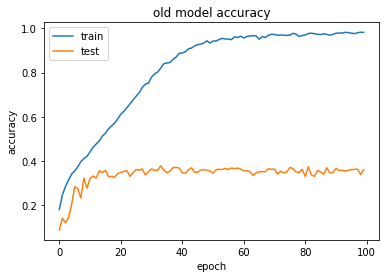

In [80]:
# Plotting the accuracy of the model
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('old model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

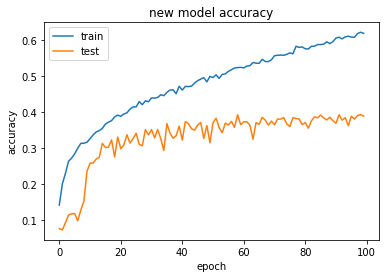

In [79]:
# Plotting the accuracy of the model
plt.plot(new_model_history.history['accuracy'])
plt.plot(new_model_history.history['val_accuracy'])
plt.title('new model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [90]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
new_model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = new_model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /home/dell/Saad/Personal/Umer Lodhi/Audio EDA/saved_models/Emotion_Model.h5 


In [91]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.Adam(lr=0.0001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 38.28%


In [92]:
# Making predictions on the testset
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 1s 7ms/step


array([ 3,  3, 10, ...,  8,  5,  0])

In [93]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_neutral
171,female_disgust,female_surprise
172,male_angry,female_angry
173,female_disgust,female_disgust
174,male_angry,female_angry
175,female_fear,male_neutral
176,male_happy,male_neutral
177,female_fear,male_happy
178,female_happy,female_happy
179,female_neutral,female_neutral


In [94]:
# Dataframing the predictions
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,372
female_disgust,309
female_fear,403
female_happy,393
female_neutral,267
female_sad,291
female_surprise,111
male_angry,157
male_disgust,68


In [96]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.3827688260440644


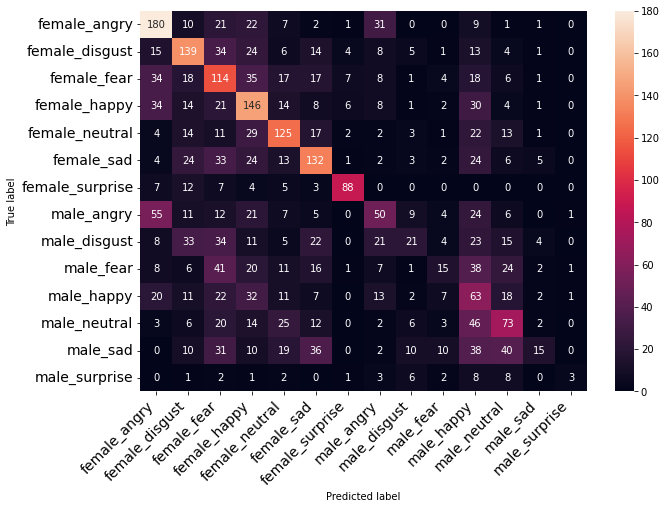

In [97]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [98]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.48      0.63      0.55       285
 female_disgust       0.45      0.52      0.48       268
    female_fear       0.28      0.41      0.33       280
   female_happy       0.37      0.51      0.43       289
 female_neutral       0.47      0.51      0.49       244
     female_sad       0.45      0.48      0.47       273
female_surprise       0.79      0.70      0.74       126
     male_angry       0.32      0.24      0.28       205
   male_disgust       0.31      0.10      0.16       201
      male_fear       0.27      0.08      0.12       191
     male_happy       0.18      0.30      0.22       209
   male_neutral       0.33      0.34      0.34       212
       male_sad       0.43      0.07      0.12       221
  male_surprise       0.50      0.08      0.14        37

       accuracy                           0.38      3041
      macro avg       0.40      0.36      0.35      3041
   weighted avg       0.39   

0.7155540940480105


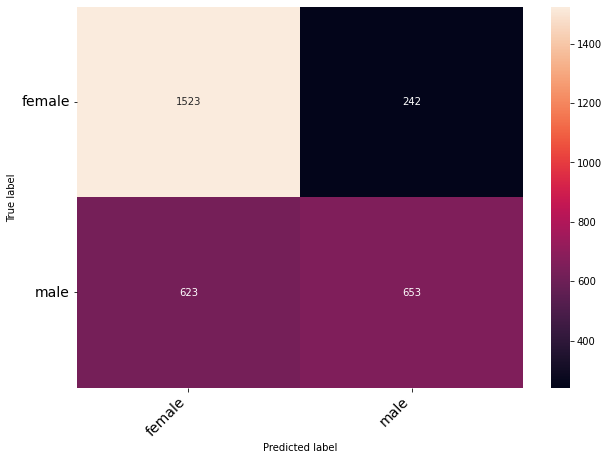

In [99]:
# Making generic classes for simplification
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [100]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.71      0.86      0.78      1765
        male       0.73      0.51      0.60      1276

    accuracy                           0.72      3041
   macro avg       0.72      0.69      0.69      3041
weighted avg       0.72      0.72      0.70      3041



0.4850378165077277


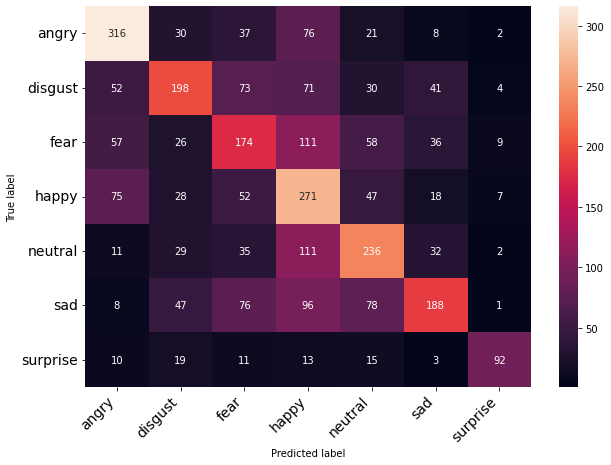

In [101]:
# Making generic classes for simplification
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [102]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))


              precision    recall  f1-score   support

       angry       0.60      0.64      0.62       490
     disgust       0.53      0.42      0.47       469
        fear       0.38      0.37      0.37       471
       happy       0.36      0.54      0.43       498
     neutral       0.49      0.52      0.50       456
         sad       0.58      0.38      0.46       494
    surprise       0.79      0.56      0.66       163

    accuracy                           0.49      3041
   macro avg       0.53      0.49      0.50      3041
weighted avg       0.50      0.49      0.49      3041



###### References: 
https://librosa.org/
https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
https://www.analyticsvidhya.com/blog/2022/03/implementing-audio-classification-project-using-deep-learning/